# Control 04 - Optimización y Calibración de Modelos
# Miguel Antonio Daza Moscoso

In [21]:
!pip install kagglehub==0.3.13
!pip install lime==0.2.0.1
!pip install onnxmltools==1.14.0 onnxruntime==1.23.2 onnxconverter-common==1.16.0

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ----------- ---------------------------- 3.7/12.9 MB 20.8 MB/s eta 0:00:01
   ------------------------------- -------- 10.2/12.9 MB 26.7 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 26.0 MB/s  0:00:00
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 21.4 MB/s  0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283918 sha256=79c78bcf55b02d6a2bf8011a8a6a569838a057f1abc47d0e14b9ac3a0508b585
  Stored in director

  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


  Using cached onnxmltools-1.14.0-py2.py3-none-any.whl.metadata (8.1 kB)
  Using cached onnxconverter_common-1.16.0-py2.py3-none-any.whl.metadata (4.8 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
  Using cached pyreadline3-3.5.4-py3-none-any.whl.metadata (4.7 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached onnxmltools-1.14.0-py2.py3-none-any.whl (352 kB)
   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
   ---------- ----------------------------- 3.7/13.5 MB 21.7 MB/s eta 0:00:01
   ---------------------------- ----------- 9.4/13.5 MB 25.5 MB/s eta 0:00:01
   ---------------------------------------- 13.5/13.5 MB 24.0 MB/s  0:00:00
Using cached onnxconverter_common-1.16.0-py2.py3-none-any.whl (89 

In [22]:
import numpy as np
import pandas as pd
# =========================================
# LIBRERÍAS BASE
# =========================================
import math
import numpy as np
import pandas as pd

# =========================================
# VISUALIZACIÓN
# =========================================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================
# CONFIGURACIÓN SKLEARN
# =========================================
from sklearn import set_config
set_config(transform_output="pandas")

# =========================================
# PREPROCESAMIENTO Y PIPELINES
# =========================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder
)
from category_encoders import TargetEncoder

# =========================================
# PARTICIÓN Y VALIDACIÓN
# =========================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score
)
from sklearn.base import clone

# =========================================
# MODELOS
# =========================================
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier, LGBMRegressor

# =========================================
# MÉTRICAS DE EVALUACIÓN
# =========================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay
)

# =========================================
# CALIBRACIÓN DE PROBABILIDADES
# =========================================
from sklearn.calibration import (
    CalibratedClassifierCV,
    CalibrationDisplay
)

# =========================================
# EXPLICABILIDAD
# =========================================
import shap


from lime.lime_tabular import LimeTabularExplainer


## 2. Introducción y Contexto de Negocio

### Descripción del problema

El objetivo es predecir el riesgo de incumplimiento (default) de un solicitante de crédito usando información financiera y personal.
El modelo busca apoyar la decisión de aprobar o rechazar un crédito, reduciendo pérdidas por clientes que no pagan y manteniendo oportunidades con buenos pagadores.

### ¿Por qué es importante explicar las predicciones en este contexto?

En créditos, las decisiones del modelo tienen impacto directo en las personas y en el negocio.
Explicar las predicciones permite entender qué variables influyen en el riesgo, asegurar que el modelo sea justo y confiable, y cumplir con requerimientos regulatorios.
Un modelo sin explicaciones claras difícilmente puede usarse en producción.

### Stakeholders que consumirán las explicaciones

* Área de Riesgos: valida que el modelo tenga sentido crediticio.
* Analistas de Negocio: usan las explicaciones para definir políticas de crédito.
* Compliance: necesita justificar decisiones ante auditorías.
* Gerencia: evalúa el impacto del modelo en riesgo y rentabilidad.

## 3. Carga de Datos y Preprocesamiento

In [23]:
import kagglehub

path = kagglehub.dataset_download("laotse/credit-risk-dataset")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/credit_risk_dataset.csv")
df.head()

Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\laotse\credit-risk-dataset\versions\1


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [25]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,32581.0,NaN,NaN,NaN,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0
person_income,32581.0,NaN,NaN,NaN,66074.84847,61983.119168,4000.0,38500.0,55000.0,79200.0,6000000.0
person_home_ownership,32581,4,RENT,16446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,31686.0,NaN,NaN,NaN,4.789686,4.14263,0.0,2.0,4.0,7.0,123.0
loan_intent,32581,6,EDUCATION,6453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,32581,7,A,10777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,32581.0,NaN,NaN,NaN,9589.371106,6322.086646,500.0,5000.0,8000.0,12200.0,35000.0
loan_int_rate,29465.0,NaN,NaN,NaN,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
loan_status,32581.0,NaN,NaN,NaN,0.218164,0.413006,0.0,0.0,0.0,0.0,1.0
loan_percent_income,32581.0,NaN,NaN,NaN,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83


In [26]:
len(df)

32581

In [27]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

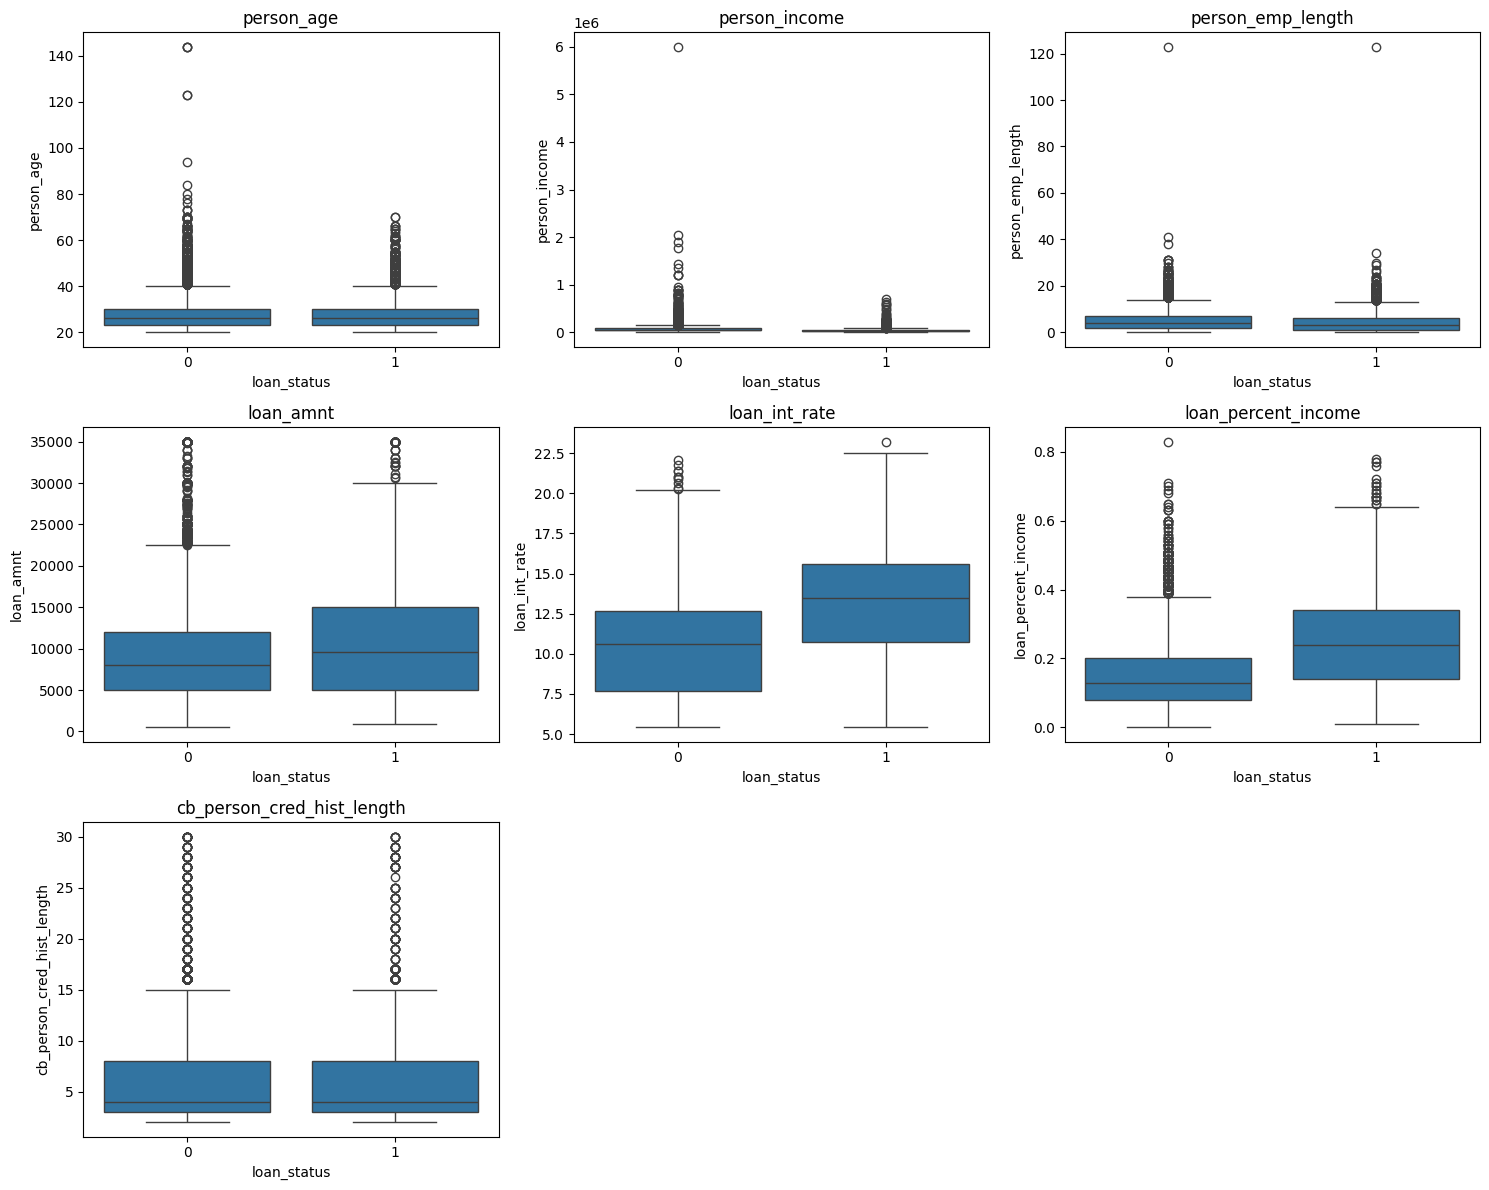

In [28]:
vars_cuantitativas= df.select_dtypes(include=['int64', 'float64']).columns.tolist()
vars_cuantitativas.remove('loan_status') 
target='loan_status'


n = len(vars_cuantitativas)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(vars_cuantitativas, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(
        x=target,
        y=col,
        data=df
    )
    plt.title(col)

plt.tight_layout()
plt.show()


In [29]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

In [31]:
X_train.shape, y_train.shape

((26064, 11), (26064,))

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc",TargetEncoder(min_samples_leaf=10))
])

In [33]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [34]:
numeric_cols

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

In [35]:
categorical_cols

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    verbose_feature_names_out=False,
    remainder='drop' 
)
preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## 4. Modelo Base (Benchmark)

In [37]:
RANDOM_STATE=42

In [38]:
lgbm_cla_pipeline = Pipeline(steps=[ 
    ("preprocessor", preprocessor), 
    ("model", LGBMClassifier(random_state=RANDOM_STATE)) ]) 
lgbm_cla_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


Estrategia 1: StratifiedKFold

Por qué aplica: en riesgo de crédito suele haber clases desbalanceadas (pocos defaults). StratifiedKFold mantiene la misma proporción de 0/1 en cada fold, haciendo la evaluación más estable.

Estrategia 2: RepeatedStratifiedKFold

Por qué aplica: además de estratificar, repite el K-Fold varias veces con diferentes particiones. Esto reduce la “suerte” de un único split y da una estimación más confiable (mejor para reportar).

Iniciando Cross-Validation...
[LightGBM] [Info] Number of positive: 4549, number of negative: 16302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 20851, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218167 -> initscore=-1.276380
[LightGBM] [Info] Start training from score -1.276380
[LightGBM] [Info] Number of positive: 4549, number of negative: 16302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 20851, number of used featu

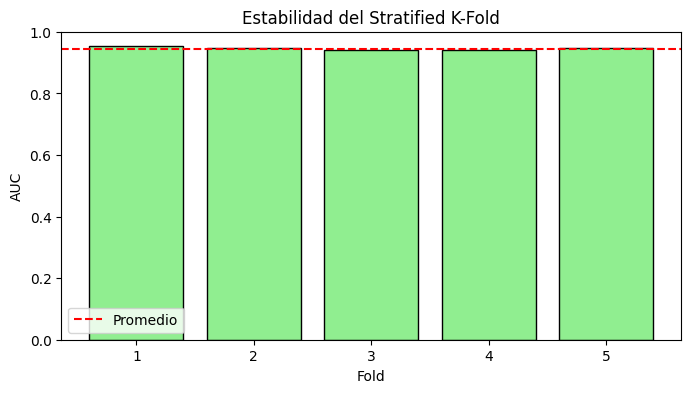

In [39]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo Base
model = lgbm_cla_pipeline

print("Iniciando Cross-Validation...")
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

print(f"\nAUC Scores por Fold: {cv_scores}")
print(f"AUC Promedio: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

plt.figure(figsize=(8, 4))
plt.bar(range(1, 6), cv_scores, color='lightgreen', edgecolor='black')
plt.axhline(cv_scores.mean(), color='red', linestyle='--', label='Promedio')
plt.title("Estabilidad del Stratified K-Fold")
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.show()


Iniciando Repeated Stratified Cross-Validation...

Total evaluaciones: 50
AUC Promedio: 0.9463 ± 0.0045


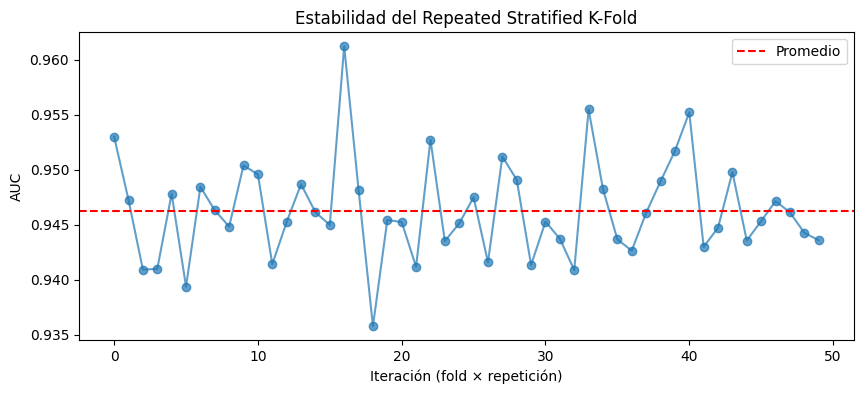

In [40]:

rskf = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=42
)

# Modelo (pipeline completo)
model = lgbm_cla_pipeline


print("Iniciando Repeated Stratified Cross-Validation...")
cv_scores = cross_val_score(
    model,
    X_train, y_train,
    cv=rskf,
    scoring="roc_auc",
    n_jobs=-1
)

print(f"\nTotal evaluaciones: {len(cv_scores)}")
print(f"AUC Promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# =========================
# Visualización de estabilidad
# =========================
plt.figure(figsize=(10, 4))
plt.plot(cv_scores, marker="o", linestyle="-", alpha=0.7)
plt.axhline(cv_scores.mean(), color="red", linestyle="--", label="Promedio")
plt.title("Estabilidad del Repeated Stratified K-Fold")
plt.xlabel("Iteración (fold × repetición)")
plt.ylabel("AUC")
plt.legend()
plt.show()


El modelo LightGBM presenta un desempeño alto y estable, con un AUC cercano a 0.95.
La validación mediante Repeated Stratified K-Fold confirma la robustez del modelo.
El indicador es similar en las 2 estrategias

In [41]:
lgbm_cla_pipeline.set_output(transform="pandas")

lgbm_cla_pipeline.fit(X_train, y_train)


y_proba = lgbm_cla_pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC (test): {auc:.4f}")

y_pred_05 = (y_proba >= 0.5).astype(int)
print("\nMétricas (threshold=0.5)")
print(classification_report(y_test, y_pred_05, digits=4))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_05))


[LightGBM] [Info] Number of positive: 5686, number of negative: 20378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218155 -> initscore=-1.276449
[LightGBM] [Info] Start training from score -1.276449
AUC-ROC (test): 0.9502

Métricas (threshold=0.5)
              precision    recall  f1-score   support

           0     0.9277    0.9953    0.9603      5095
           1     0.9772    0.7222    0.8306      1422

    accuracy                         0.9357      6517
   macro avg     0.9524    0.8588    0.8954      6517
weighted avg     0.9385    0.9357    0.9320      6517

Matriz de confusión:
 [[5071   24]
 [ 395 1027]]


## 3. Explainable AI con SHAP

### 3.1 Interpretación Global

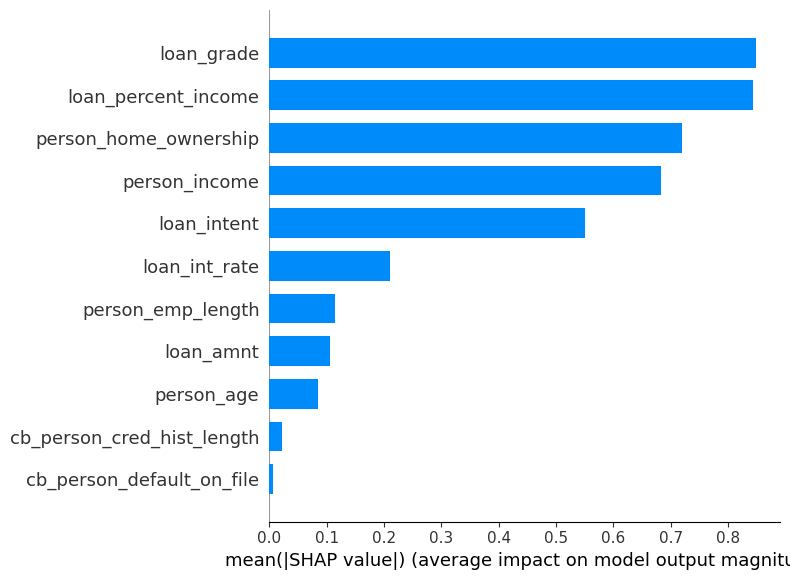

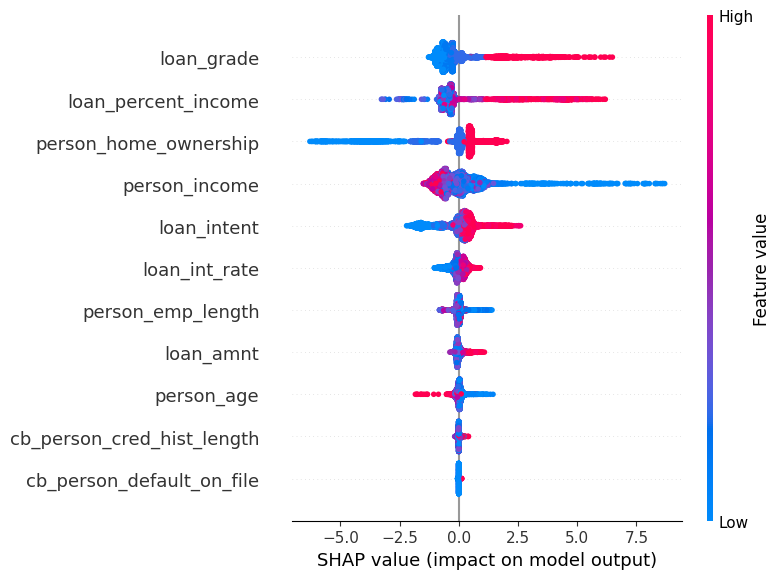

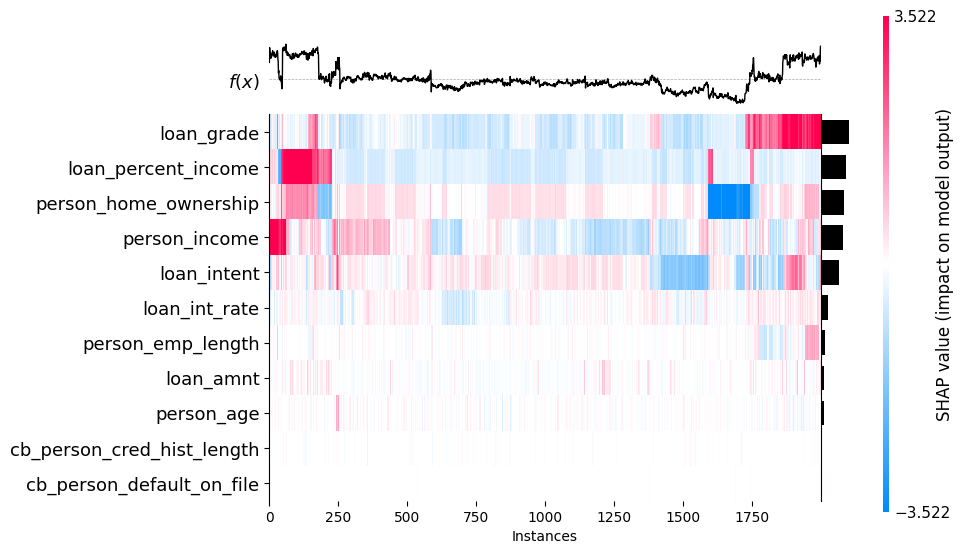

<Axes: xlabel='Instances'>

In [42]:


preprocess = lgbm_cla_pipeline.named_steps["preprocessor"]
model = lgbm_cla_pipeline.named_steps["model"]


X_test_tr = preprocess.transform(X_test)
if hasattr(X_test_tr, "toarray"):
    X_test_tr = X_test_tr.toarray()

try:
    feature_names = list(preprocess.get_feature_names_out())
except Exception:
    feature_names = None


explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_tr)   # shap.Explanation


shap.summary_plot(
    shap_values.values, X_test_tr,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)

shap.summary_plot(
    shap_values.values, X_test_tr,
    feature_names=feature_names,
    max_display=20
)


n = min(2000, X_test_tr.shape[0])     # 500–2000 suele ser suficiente
idx = np.random.RandomState(42).choice(X_test_tr.shape[0], n, replace=False)

shap.plots.heatmap(shap_values[idx], max_display=20)




### SHAP Bar Plot

Este gráfico muestra qué variables son las que más influyen en las predicciones del modelo de riesgo crediticio en promedio. Se observa que loan_grade, loan_percent_income y person_home_ownership concentran la mayor importancia, lo que indica que el modelo se apoya principalmente en la calidad del crédito y en la capacidad de pago del cliente.


### SHAP Beeswarm Plot
Este gráfico permite entender cómo influyen las variables sobre el riesgo: si aumentan o reducen la probabilidad de default. Se observa que valores altos de loan_percent_income y peores loan_grade empujan la predicción hacia mayor riesgo, mientras que ingresos más altos y ciertos tipos de home ownership reducen la probabilidad de incumplimiento.

### SHAP Heatmap
Este gráfico muestra cómo las contribuciones de cada variable varían a lo largo de todos los clientes evaluados. Se aprecian patrones consistentes donde algunos grupos de clientes acumulan impactos positivos (mayor riesgo) y otros impactos negativos (menor riesgo), especialmente en las variables más importantes.

### 3.2 Interpretación Local

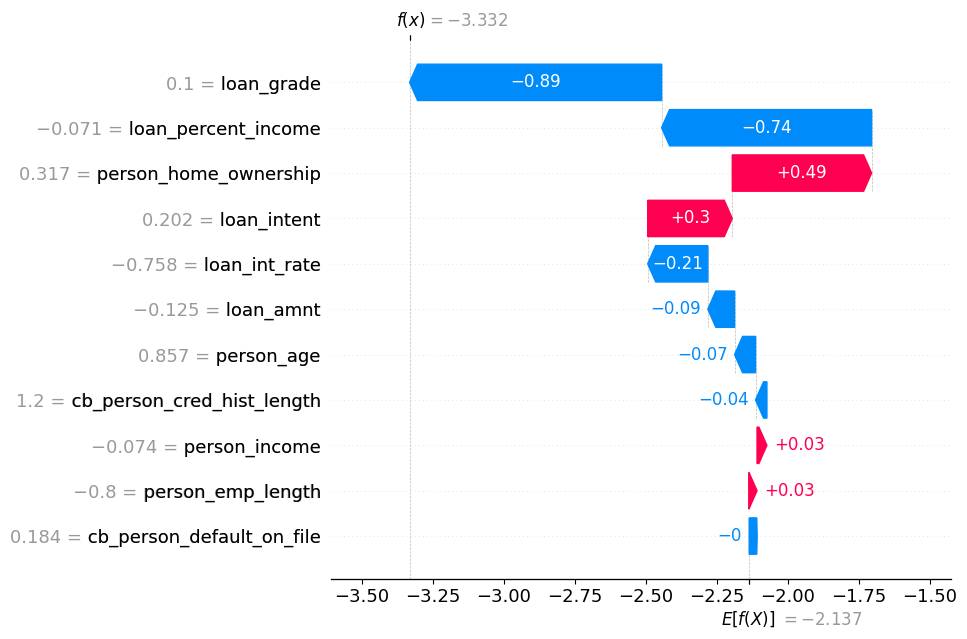

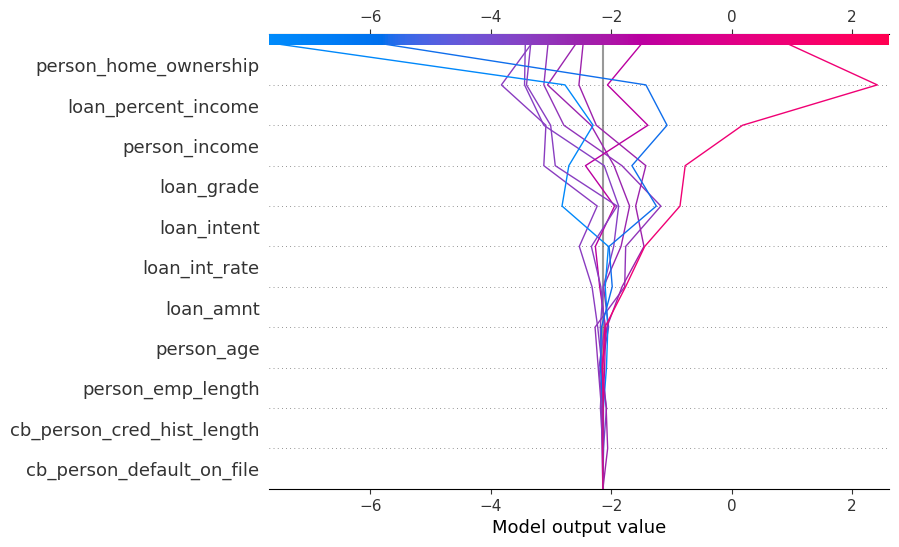

\Datos:
Sube por: person_home_ownership (+0.462), loan_int_rate (+0.290), loan_intent (+0.142), person_age (+0.119), cb_person_cred_hist_length (+0.006). Baja por: loan_percent_income (-0.723), person_income (-0.381), loan_grade (-0.259), loan_amnt (-0.084), person_emp_length (-0.028).


In [43]:

# Waterfall + Decision + Narrativa
idxs = [1 ]  
for i in idxs:
    shap.plots.waterfall(shap_values[i], max_display=15)

# expected_value (binaria a veces es array)
expected_value = explainer.expected_value
if isinstance(expected_value, (list, np.ndarray)) and np.ndim(expected_value) > 0:
    expected_value = expected_value[1]

shap.plots.decision(
    expected_value,
    shap_values.values[:10],
    feature_names=feature_names
)

def narrativa_shap(shap_i, top_k=5):
    vals = shap_i.values
    names = np.array(feature_names) if feature_names is not None else np.array([f"f{j}" for j in range(len(vals))])

    pos = np.argsort(vals)[-top_k:][::-1]  # suben la probabilidad
    neg = np.argsort(vals)[:top_k]         # bajan la probabilidad

    pos_txt = ", ".join([f"{names[j]} ({vals[j]:+.3f})" for j in pos])
    neg_txt = ", ".join([f"{names[j]} ({vals[j]:+.3f})" for j in neg])

    return f"Sube por: {pos_txt}. Baja por: {neg_txt}."

print("\Datos:")
print(narrativa_shap(shap_values[0], top_k=5))

### SHAP Waterfall
La calificación crediticia favorable y la baja carga del préstamo respecto a sus ingresos son los principales factores que reducen la probabilidad de incumplimiento. Aunque existen elementos que presionan ligeramente el riesgo, como la tenencia de vivienda y el destino del crédito, estos no son suficientes para contrarrestar los factores positivos, resultando en una evaluación final claramente favorable.

### SHAP Decision Plot
Este gráfico muestra el recorrido de la predicción del cliente a medida que se incorporan las variables. Desde las variables más importantes, la predicción se desplaza claramente hacia valores de menor riesgo, y las variables restantes apenas modifican el resultado. Esto indica que la decisión del modelo es estable y bien sustentada.

### 3.3 Dependencias

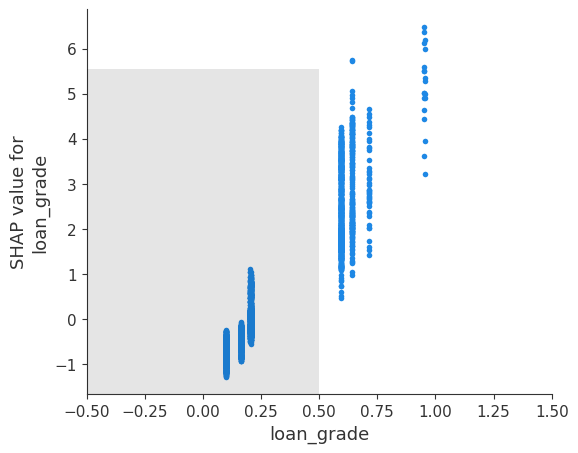

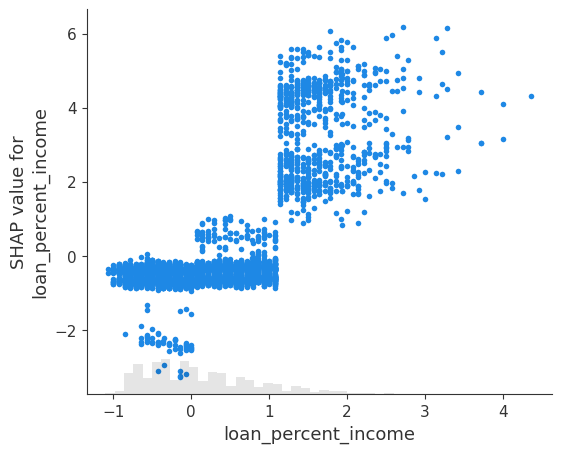

In [44]:

mean_abs = np.abs(shap_values.values).mean(axis=0)
top2_idx = np.argsort(mean_abs)[-2:][::-1]

for j in top2_idx:
    fname = feature_names[j] if feature_names is not None else j
    # scatter moderno si acepta nombre, si no, usa índice
    try:
        shap.plots.scatter(shap_values[:, fname])
    except Exception:
        shap.plots.scatter(shap_values[:, j])


### Loan_grade

Este gráfico muestra que a medida que empeora el loan_grade, el impacto SHAP aumenta de forma no lineal, empujando la predicción hacia mayor riesgo de default. Para valores bajos del loan_grade, el impacto es negativo o cercano a cero, lo que reduce el riesgo, pero a partir de cierto punto el efecto crece rápidamente. Esto indica que el modelo penaliza fuertemente los grados de préstamo más riesgosos, incluso más allá de una relación lineal simple.


### Loan_percent_income
Este gráfico muestra una relación claramente creciente y no lineal entre el porcentaje del ingreso destinado al préstamo y el riesgo. Cuando el loan_percent_income es bajo, el impacto en el riesgo es mínimo o incluso negativo; sin embargo, al superar ciertos umbrales, el SHAP aumenta bruscamente, elevando la probabilidad de default. La dispersión vertical sugiere que esta variable interactúa con otras.

### Lime


[LightGBM] [Info] Number of positive: 5686, number of negative: 20378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218155 -> initscore=-1.276449
[LightGBM] [Info] Start training from score -1.276449
Cliente index=21802
P(Default)    = 0.0345  (3.45%)
P(No Default) = 0.9655  (96.55%)


c:\Users\Usuario\miniconda3\envs\ml_pro\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


person_home_ownership             RENT
loan_percent_income               0.12
loan_grade                           B
loan_intent                   PERSONAL
person_age                          22
person_emp_length                  6.0
loan_amnt                         6000
person_income                    50000
cb_person_default_on_file            N
cb_person_cred_hist_length           2
loan_int_rate                    11.89
Name: 6616, dtype: object

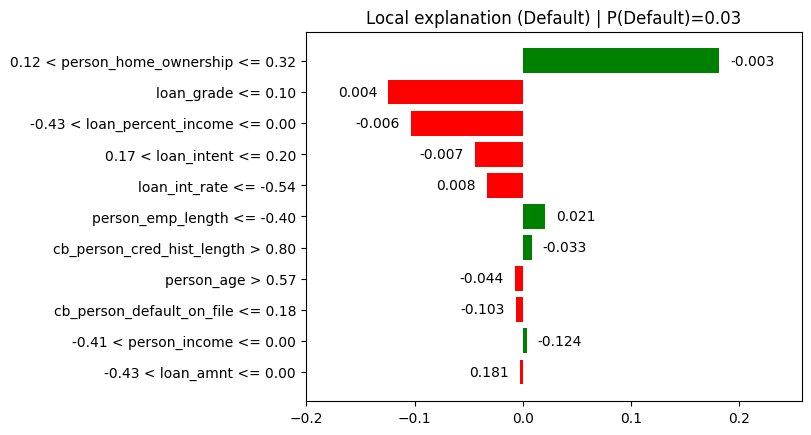

In [45]:
from lime.lime_tabular import LimeTabularExplainer

lgbm_cla_pipeline.set_output(transform="pandas")
lgbm_cla_pipeline.fit(X_train, y_train)

preprocess = lgbm_cla_pipeline.named_steps["preprocessor"]
model = lgbm_cla_pipeline.named_steps["model"]

# 1) Transformar
X_train_tr = preprocess.transform(X_train)
X_test_tr  = preprocess.transform(X_test)

# 2) Feature names (si hay DataFrame, toma columnas; si no, usa get_feature_names_out)
if hasattr(X_train_tr, "columns"):
    feature_names_tr = X_train_tr.columns.tolist()
else:
    try:
        feature_names_tr = list(preprocess.get_feature_names_out())
    except Exception:
        feature_names_tr = [f"f{i}" for i in range(X_train_tr.shape[1])]

# 3) Convertir SIEMPRE a numpy (clave para LIME)
X_train_tr_np = np.asarray(X_train_tr)  # funciona para DataFrame y ndarray
X_test_tr_np  = np.asarray(X_test_tr)

# 4) LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_tr_np,
    feature_names=feature_names_tr,
    class_names=["No Default", "Default"],
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

def predict_proba_lime_tr(X):
    # X llega como ndarray (transformado)
    return model.predict_proba(X)

i = 1
exp = lime_explainer.explain_instance(
    data_row=X_test_tr_np[i],
    predict_fn=predict_proba_lime_tr,
    num_features=15
)


proba_default = lgbm_cla_pipeline.predict_proba(X_test.iloc[[i]])[0, 1]
proba_no_default = lgbm_cla_pipeline.predict_proba(X_test.iloc[[i]])[0, 0]

print(f"Cliente index={X_test.index[i]}")
print(f"P(Default)    = {proba_default:.4f}  ({proba_default*100:.2f}%)")
print(f"P(No Default) = {proba_no_default:.4f}  ({proba_no_default*100:.2f}%)")


exp.show_in_notebook(show_table=True)


fig = exp.as_pyplot_figure()
ax = fig.axes[0]

# Lista de (feature_regla, peso)
lime_list = exp.as_list()


if len(ax.patches) == len(lime_list):
    values = [v for _, v in lime_list]
else:
    values = [v for _, v in lime_list[:len(ax.patches)]]

# Annotate
for rect, v in zip(ax.patches, values):
    x = rect.get_width()
    y = rect.get_y() + rect.get_height() / 2

    ax.text(
        x + (0.01 if x >= 0 else -0.01),
        y,
        f"{v:.3f}",
        va="center",
        ha="left" if x >= 0 else "right",
        fontsize=10,
        color="black"
    )

fig.patch.set_facecolor("white")
ax.set_facecolor("white")
ax.set_title(
    f"Local explanation (Default) | P(Default)={proba_default:.2f}",
    fontsize=12
)


ax.margins(x=0.25)  

i = 0
display(X_test.iloc[i][["person_home_ownership","loan_percent_income","loan_grade","loan_intent",
                        "person_age","person_emp_length","loan_amnt","person_income",
                        "cb_person_default_on_file","cb_person_cred_hist_length","loan_int_rate"]])




El cliente presenta un perfil financiero sólido, con ingresos estables y ausencia de antecedentes negativos, lo que reduce significativamente la probabilidad de incumplimiento. No obstante, su limitada experiencia crediticia y el costo del préstamo ejercen una presión moderada al alza sobre el riesgo, aunque insuficiente para revertir la evaluación favorable, resultando en una probabilidad de default baja (3%).

## 4. Serialización del Modelo

In [46]:
X_test_tr = preprocess.transform(X_test)

### Joblib

In [47]:
import joblib
import os
import numpy as np


model_path = "../app/models/model.joblib"

joblib.dump(lgbm_cla_pipeline, model_path, compress=3)


model_joblib = joblib.load(model_path)

pred_orig = lgbm_cla_pipeline.predict_proba(X_test)[:, 1]
pred_load = model_joblib.predict_proba(X_test)[:, 1]

assert np.allclose(pred_orig, pred_load)
print("Joblib: predicciones verificadas correctamente")

size_joblib = os.path.getsize(model_path) / 1024
print(f"Tamaño Joblib: {size_joblib:.2f} KB")


Joblib: predicciones verificadas correctamente
Tamaño Joblib: 145.73 KB


### Pickle

In [48]:
import pickle
import os
import numpy as np

# Ruta del modelo

model_path = "../app/models/model_credit_scoring.pkl"

with open(model_path, "wb") as f:
    pickle.dump(lgbm_cla_pipeline, f)

with open(model_path, "rb") as f:
    model_pickle = pickle.load(f)

pred_load_pkl = model_pickle.predict_proba(X_test)[:, 1]
assert np.allclose(pred_orig, pred_load_pkl)
print("Pickle: predicciones verificadas correctamente")


size_pickle = os.path.getsize(model_path) / 1024
print(f"Tamaño Pickle: {size_pickle:.2f} KB")


Pickle: predicciones verificadas correctamente
Tamaño Pickle: 346.63 KB


### ONNX

In [49]:

import os, time
import numpy as np
import onnxruntime as ort
from sklearn.metrics import roc_auc_score
from onnxmltools.convert import convert_lightgbm
from onnxmltools.convert.common.data_types import FloatTensorType

onnx_path = "../app/models/model_onnx.onnx"

preprocess = lgbm_cla_pipeline.named_steps["preprocessor"]
model = lgbm_cla_pipeline.named_steps["model"]

X_test_tr = preprocess.transform(X_test)
X_test_np = np.asarray(X_test_tr).astype(np.float32)

initial_type = [("input", FloatTensorType([None, X_test_np.shape[1]]))]

start = time.time()
onnx_model = convert_lightgbm(
    model.booster_,
    initial_types=initial_type,
    target_opset=12,
    zipmap=False
)
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())
onnx_save_time = time.time() - start

start = time.time()
sess = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
onnx_load_time = time.time() - start

input_name = sess.get_inputs()[0].name

start = time.time()
outs = sess.run(None, {input_name: X_test_np})
onnx_inference_time = time.time() - start

proba = outs[1]
pred_onnx = proba[:, 1] if (isinstance(proba, np.ndarray) and proba.ndim == 2) else np.asarray(proba).ravel()

auc_onnx = roc_auc_score(y_test, pred_onnx)
onnx_size = os.path.getsize(onnx_path) / 1024

print(f"Archivo: {onnx_path}")
print(f"Tamaño: {onnx_size:.2f} KB")
print(f"Tiempo conversión+guardado: {onnx_save_time*1000:.2f} ms")
print(f"Tiempo cargar: {onnx_load_time*1000:.2f} ms")
print(f"Tiempo inferencia ({len(X_test)} muestras): {onnx_inference_time*1000:.2f} ms")
print(f"AUC ONNX: {auc_onnx:.4f}")


Archivo: ../app/models/model_onnx.onnx
Tamaño: 218.49 KB
Tiempo conversión+guardado: 206.39 ms
Tiempo cargar: 56.31 ms
Tiempo inferencia (6517 muestras): 10.47 ms
AUC ONNX: 0.9502


### Metadatos 

In [50]:
import json
from datetime import datetime

metadata_path = "../app/models/model_metadata.json"

metadata = {
    "model_name": "credit_scoring_lgbm",
    "version": "1.0.0",
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "algorithm": "LightGBM",
    "serialization_formats": ["joblib", "pickle", "lightgbm_native"],
    "features": list(X.columns),
    "metrics": {
        "auc_cv": float(np.mean(cv_scores)),
        "auc_test": float(auc)
    },
    "threshold": 0.35,
    "business_context": "Credit Risk / Default Prediction"
}


with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)

print("Metadatos del modelo guardados correctamente")
print(f"Ruta: {metadata_path}")


Metadatos del modelo guardados correctamente
Ruta: ../app/models/model_metadata.json


### 5. Conclusiones del Análisis

## Top 3 variables más importantes y su interpretación

Las variables más influyentes del modelo son **loan_grade**, **loan_percent_income** y **person_home_ownership**.  
El **loan_grade** resume la calidad crediticia del cliente y es el principal determinante del riesgo: un peor grado incrementa claramente la probabilidad de default, mientras que un mejor grado la reduce.  
El **loan_percent_income** refleja la carga financiera del préstamo sobre el ingreso del cliente y muestra que, al superar ciertos niveles, el riesgo aumenta de forma acelerada, evidenciando situaciones de estrés financiero.  
Por último, **person_home_ownership** actúa como un indicador de estabilidad económica, diferenciando perfiles más y menos riesgosos según la tenencia de vivienda.

---

## Insights de negocio derivados de SHAP

Los resultados indican que el riesgo crediticio está explicado principalmente por la **capacidad de pago y la calidad del crédito**, más que por variables demográficas.  
Asimismo, se identifican **umbrales críticos de endeudamiento** a partir de los cuales el riesgo se incrementa con mayor intensidad, lo que permite segmentar de manera clara a los clientes según su perfil financiero.  
En conjunto, el comportamiento del modelo es consistente y alineado con la lógica del negocio.

---

## Recomendaciones para stakeholders no técnicos

Se recomienda reforzar las políticas de evaluación crediticia basadas en **límites claros de endeudamiento sobre ingresos**, ya que este es uno de los principales drivers del riesgo.  
El **loan_grade** debe utilizarse como eje central en la toma de decisiones, complementándolo con variables de estabilidad económica.  
Finalmente, las explicaciones basadas en SHAP permiten **comunicar de forma transparente** las decisiones de aprobación o rechazo, fortaleciendo la confianza del regulador y de los equipos comerciales.
